# Dimensionality Reduction II, Manifold Learning

In this notebook we end our material on unsupervised learning by introducing a large field of dimension reduction techniques, <i>manifold learning</i>.

We'll first discuss the need for manifold learning then demonstrate a few popular techniques. A disclaimer that this is a large subfield with many techniques. You may want to check out the Wikipedia entry to see what other techniques exist, <a href="https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction">https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction</a>.

## What You'll Accomplish

We'll
<ul>
    <li>work through a simple example where techniques like PCA and Multi-Dimensional Scaling fail,</li>
    <li>discuss why those techniques fail, and how manifold techniques address those inadequacies,</li>
    <li>see local linear embeddings,</li>
    <li>see isomap, and</li>
    <li>tSNE.</li>
</ul>

In [1]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

For this notebook we'll be working through this excerpt, <a href="https://jakevdp.github.io/PythonDataScienceHandbook/05.10-manifold-learning.html">https://jakevdp.github.io/PythonDataScienceHandbook/05.10-manifold-learning.html</a>, of the book <a href="http://shop.oreilly.com/product/0636920034919.do">Python Data Science Handbook</a>.

## Hello

As I mentioned we'll demonstrate the need for manifold learning with a simple example.

The following code was written by Jake VanderPlas.

In [2]:
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]


In [3]:
# Make our data
X = make_hello(1000)

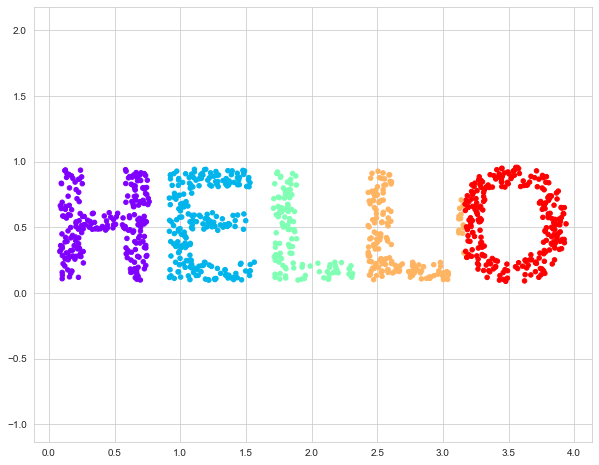

In [4]:
# Plot it in 2D
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5), s = 20)

plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal')

plt.show()

We can recognize this as HELLO under a number of different transformations: rotations, scalings, flips, and translations. All that needs to be preserved is the distance between pairwise points.

For example if we rotate it it will still look like HELLO

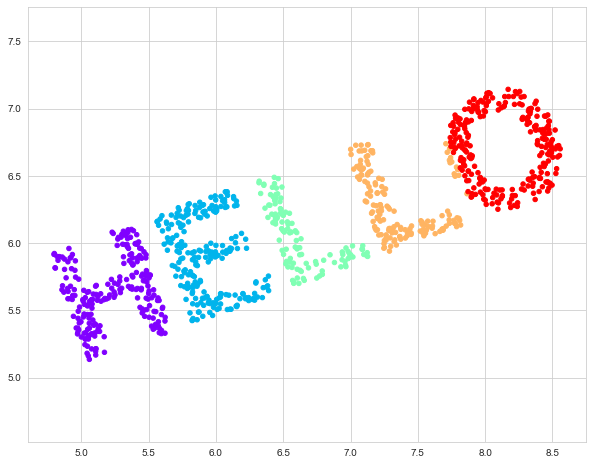

In [5]:
# More code from Jake
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    
X2 = rotate(X, 20) + 5

plt.figure(figsize=(10,8))
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

The idea behind all of the techniques we review in this notebook is the thought that while we reduce the dimension of the data we want to preserve the "distance" between points, where our concept of distance will change depending on the technique.

## Multidimensional Scaling (MDS)

MDS looks at the problem of preserving distances as a problem of preserving pairwise Euclidean distances between each pair of points in the data set. It does this by computing an $n$ by $n$ matrix where the $i,j$ entry is the Euclidean distance between data point $i$ and data point $j$.

For the mathematics behind how this distance is preserved I encourage you to read the wikipedia entry on MDS, <a href="https://en.wikipedia.org/wiki/Multidimensional_scaling">https://en.wikipedia.org/wiki/Multidimensional_scaling</a>.

We'll work through a silly example performing MDS on the rotated 2D data so you can see how it is implemented. Then you'll work on applying it to two 3D examples where our 2D data is embedded into a 3D space.

Here is the `sklearn` docs page on MDS, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html">https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html</a>.

In [6]:
# MDS is stored in
from sklearn.manifold import MDS

In [7]:
# Set the number of output dimensions to be 2
mds = MDS(n_components = 2)
X_mds = mds.fit_transform(X2)

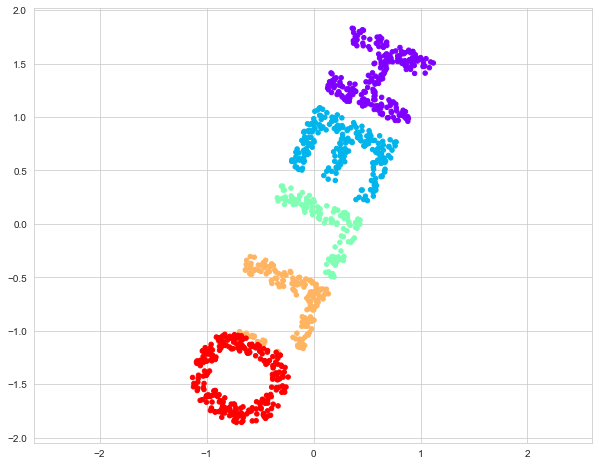

In [8]:
plt.figure(figsize=(10,8))
plt.scatter(X_mds[:, 0], X_mds[:, 1], **colorize)
plt.axis('equal')

plt.show()

In [9]:
# What about for 1D?
mds = MDS(n_components = 1)
X_mds = mds.fit_transform(X2)

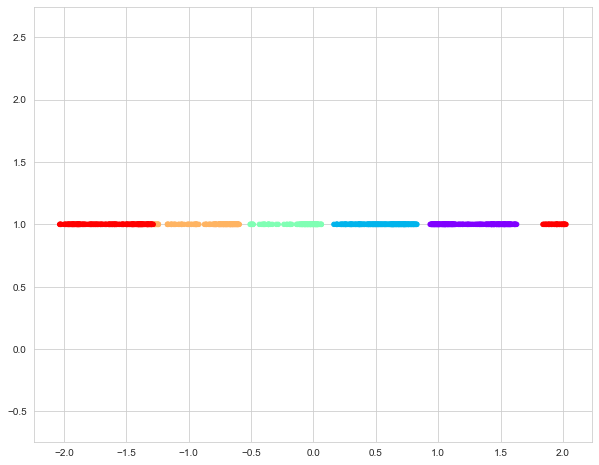

In [10]:
plt.figure(figsize=(10,8))
plt.scatter(X_mds[:, 0], np.ones(len(X[:,0])), **colorize)
plt.axis('equal')

plt.show()

## Practice

Below you'll work through applying MDS to two separate 3D embeddings of our 2D HELLO data. One embeds the data onto a 2D plane in 3-space. The other embeds into onto a 3D S surface.

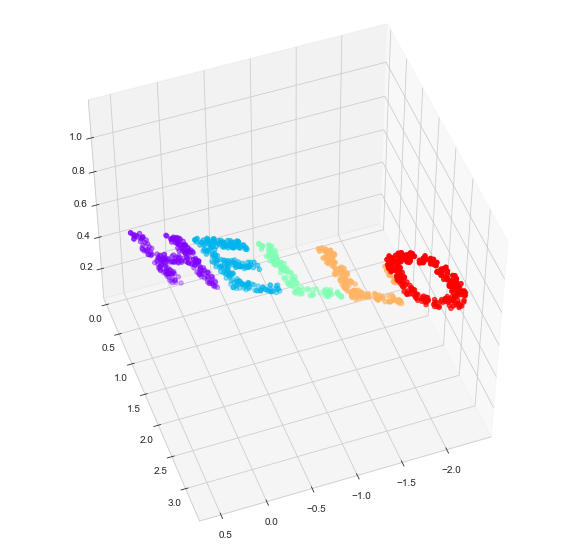

In [18]:
# More code from Jake
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
X3.shape

plt.figure(figsize=(10,10))

ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)

In [19]:
# apply MDS to X3 here.
mds = MDS(n_components = 2)

X_mds = mds.fit_transform(X3)
X_mds


array([[ 0.8222029 ,  1.67020467],
       [ 1.11533607,  1.48403036],
       [ 0.82758104,  1.66148879],
       ...,
       [-0.9158292 , -1.77090079],
       [-1.14589078, -1.62971615],
       [-1.02713612, -1.71773992]])

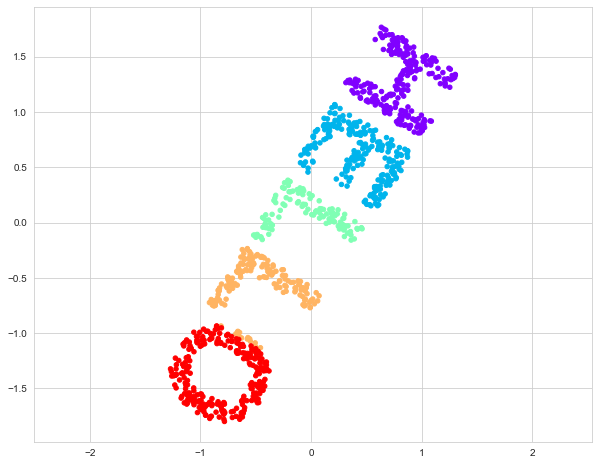

In [20]:
# plot the result in 2D here

plt.figure(figsize=(10,8))
plt.scatter(X_mds[:, 0], X_mds[:, 1], **colorize)
plt.axis('equal')

plt.show()


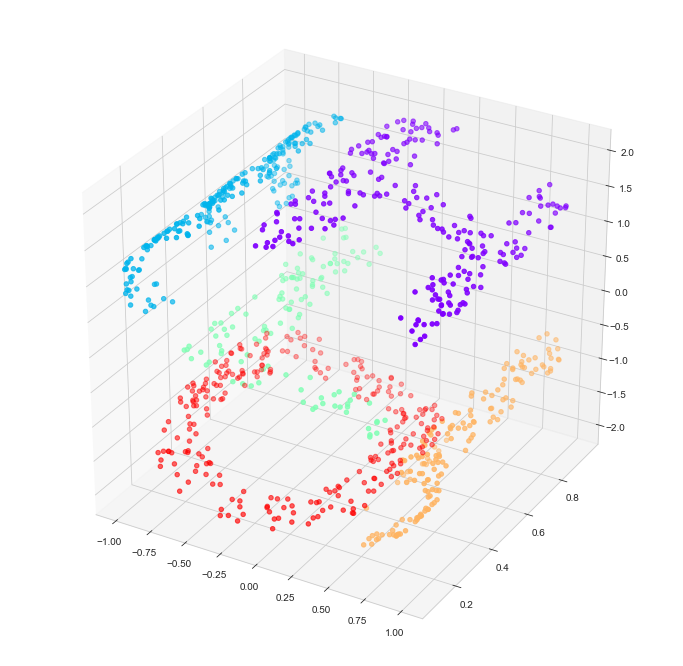

In [21]:
# Thanks again for more code Jake
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

plt.figure(figsize=(12,12))

ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize);

In [22]:
# apply MDS to XS here.

X_mds = mds.fit_transform(XS)




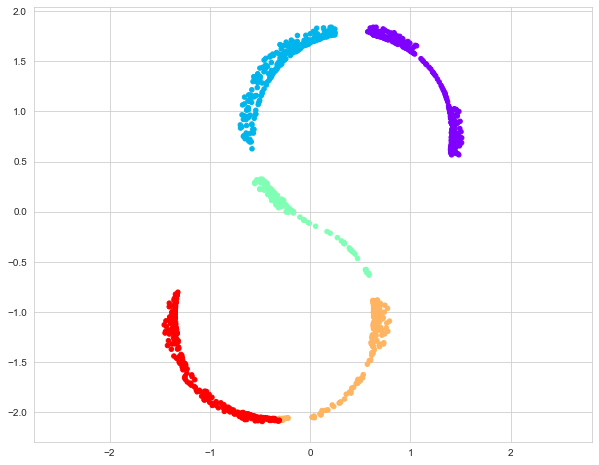

In [23]:
# plot the result in 2D here

plt.figure(figsize=(10,8))
plt.scatter(X_mds[:, 0], X_mds[:, 1], **colorize)
plt.axis('equal')

plt.show()


In [ ]:
# As a comparison perform PCA on X3 and XS
# plot the comparisons below in 2D




In [ ]:
# plot the PCA transform on X3 here







In [ ]:
# plot the PCA transform on XS here





Both MDS and PCA are good at dimensionality reduction on low dimensional data that has been embedded into a higher dimensional space in some "linear" way. For example, how we put HELLO into 3D by placing it on a plane.

However, they tend to fail on lower dimensional data that has been embedded into higher dimensions in a nonlinear way, like with the S surface data.

The underlying reason is that these techniques perform on the global scale (for MDS this meant looking at the pairwise Euclidean distances between all points), which inherently has an assumption that the embedding is onto a Euclidean space. However, this as we saw with the S surface this isn't always the case.

So what to do? Enter the manifold of manifold learning.

### <i>Manifold</i> Learning

While the S shape is not Euclidean space, it is locally Euclidean. If you have ever asked what a manifold is, you've probably heard something like "it's a space that you can think of as being locally Euclidean". So where PCA and MDS fail is performing global measures of closeness.

However, if we restrict ourselves to local measures of closeness we may be able to preserve the inherent structure of our data. Thinking in terms of our HELLO data set if we use local measures we may be able to recover the HELLO off the S curve when shrinking back to 2D.

We now introduce three different techniques each of which measures local relationships between points in a slightly different way. We'll give a brief intuition into the technique but leave reading on the exact method to you.

### Local Linear Embeddings

To see a more thorough discussion read this introduction to the topic from Saul and Roweis, <a href="https://cs.nyu.edu/~roweis/lle/papers/lleintro.pdf">https://cs.nyu.edu/~roweis/lle/papers/lleintro.pdf</a>.

Local Linear Embeddings are in essence a $k$ nearest neighbors method. Using some sort of distance measure, for each observation, $X_i$, you attempt to reconstruct $X_i$ with a weighted sum of its $k$ neighbors. The algorithm then attempts to choose the $W$ that minimizes:
$$
\sum_{i=1}^n \left| X_i - \sum_{j=1}^n W_{ij} X_j \right|^2
$$
where $W_{ij} = 0$ for any $j$ that is not the index of one of $X_i$'s $k$ nearest neighbors, and $\sum_j W_{ij} = 1$.

To get the lower dimension (say it is $\tilde{m}$), we choose an $n$ by $\tilde{m}$ matrix $Y$ that minimizes:
$$
\sum_{i=1}^n \left| Y_i - \sum_{j=1}^n W_{ij} Y_j \right|^2
$$.

Let's see how to implement it using `sklearn`, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html">https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html</a>

In [24]:
# import it from manifold
from sklearn.manifold import LocallyLinearEmbedding

In [25]:
# We use a modified version of the algorithm to get nice
# results. Check out the docs to see what that means
lle = LocallyLinearEmbedding(n_neighbors=100, n_components=2,method='modified',
                               eigen_solver='dense')
X_lle = lle.fit_transform(XS)

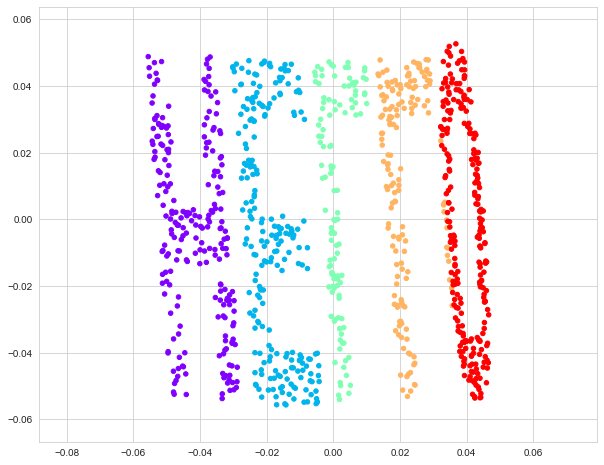

In [26]:
plt.figure(figsize=(10,8))
plt.scatter(X_lle[:, 0], X_lle[:, 1], **colorize)
plt.axis('equal')

plt.show()

### Isomap

To see more in depth discussions of the algorithm see here, <a href="https://web.mit.edu/cocosci/isomap/isomap.html">https://web.mit.edu/cocosci/isomap/isomap.html</a> and <a href="https://blog.paperspace.com/dimension-reduction-with-isomap/">https://blog.paperspace.com/dimension-reduction-with-isomap/</a>.
    
Isomap stands for isometric mapping. Here is the algorithm in a nutshell.

The algorithm takes in the dataset and constructs "neighborhood graphs", where here we mean graph in the <a href="https://en.wikipedia.org/wiki/Graph_theory">graph theoretic sense</a>. Then local distance is determined using distance measured using graph distance instead of Euclidean distance in the data space. The algorithm then tries to reduce the dimensionality while preserving the geodesic distance.

Again for a more mathematical explanation check out the MIT link above.

We now implement it on the HELLO S surface data. Here are the `sklearn` docs on `Isomap`, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html">https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html</a>. 

In [27]:
# we import isomap from manifold
from sklearn.manifold import Isomap

In [28]:
# you control the number
iso = Isomap(n_neighbors=160, n_components=2)
X_iso = iso.fit_transform(XS)

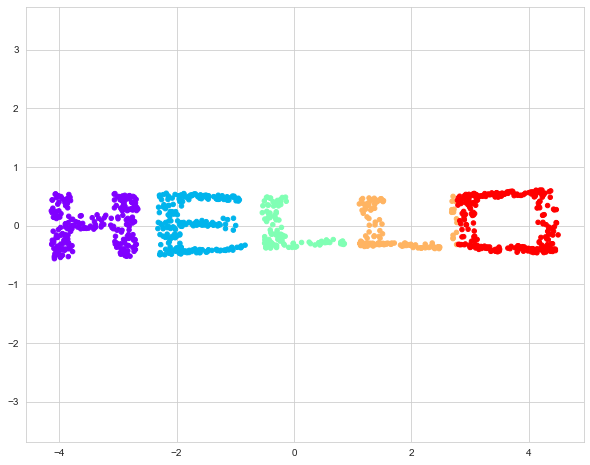

In [29]:
plt.figure(figsize=(10,8))
plt.scatter(X_iso[:, 0], X_iso[:, 1], **colorize)
plt.axis('equal')

plt.show()

Local Linear Embedding (LLE) and Isomap are quite similar. LLE often does not perform well on high dimensional data, but does quite well on lower dimensional data. In contrast Isomap has been demonstrated to perform quite well on high dimensional data.

### t-distributed Stochastic Neighbor Embedding (tSNE)

We'll give a brief overview of how the algorithm works here. For the rigorous treatment see Visualizing Data using tSNE by Laurens van der Maaten and Geoffrey Hinton, <a href="http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf">http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf</a>.

Here's a basic outline of the algorithm:
1. For all points $x_i$, $x_j$, convert their Euclidean distance into a conditional probability $p_{j|i}$. This is done by imagining a Gaussian distribution around $x_i$ and then comparing the "normal distance" of $x_j$ vs the sum of all other "normal distances". Here's a precise mathematical formula:
$$
p_{j|i} = \frac{\exp(-||x_i - x_j||^2/2\sigma_i^2)}{\sum_{k\neq i} \exp(-||x_i - x_k||^2/2\sigma_i^2)}
$$
Think of $p_{j|i}$ as the probability that $x_i$ would choose $x_j$ as its neighbor. We take $p_{i|i} = 0$.
2. For every point $x_i$ in high dimensional space we will have a low dimensional counterpart, $y_i$, to which we map $x_i$. Similar to $p_{j|i}$ we will have $q_{j|i}$ that gives the probability that $y_i$ would choose $y_j$ as a neighbor. Here is the precise mathematical formula they are using:
$$
q_{j|i} = \frac{(1 + ||y_i - y_j||^2)^{-1}}{\sum_{k\neq l} (1 + ||y_k - y_l||^2)^{-1}}
$$
We take $q_{i,i} = 0$. Note: this is where the $t$ comes from! The numerator and denominator of $q_{j|i}$ is from the probability density for the $t$ distribution with 1 degree of freedom.
3. Now if we're preserving these pairwise distances well, then we should expect $p_{j|i}$ to be close to $q_{j|i}$. In order to do this a cost function that measures the difference between $p_{j|i}$ and $q_{j|i}$ is minimized using gradient descent. The optimal $y_i$s are then spit out by the algorithm.


You may be wondering how $\sigma_i$ is chosen. The idea behind letting $\sigma_i$ vary with $i$ is that some regions of the data are much denser than others. Changing $\sigma_i$ with $i$ allows the algorithm to essentially control the number of neighbors of $x_i$ it considers. We can control this in $tSNE$ by specifying a perplexity. Typical values for perplexity are in 5 to 50.

If you'd like a more in depth non research paper explanation of tSNE check out this blog post, http://mlexplained.com/2018/09/14/paper-dissected-visualizing-data-using-t-sne-explained/. I think the author does a great job explaining it.

Let's apply the algorithm to HELLO S curve and see what happens. <a href="https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html">https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html</a>.

In [31]:
from sklearn.manifold import TSNE

In [32]:
# we set perplexity = 50
tsne = TSNE(n_components = 2, perplexity=50, random_state = 440)
X_tsne = tsne.fit_transform(XS)

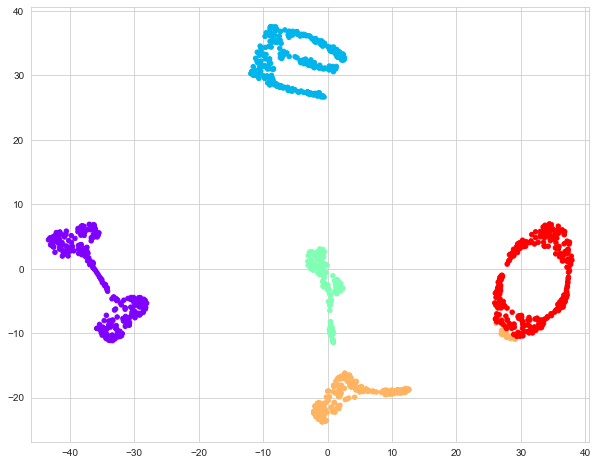

In [33]:
plt.figure(figsize=(10,8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], **colorize)
plt.axis('equal')

plt.show()

Note that tSNE can only be used for data visualization, DO NOT use it for any sort of supervised learning task like classification or regression, as tempting as it might be. Check out this Stack Exchange post for a discussion as to why you can't <a href="https://stats.stackexchange.com/questions/340175/why-is-t-sne-not-used-as-a-dimensionality-reduction-technique-for-clustering-or">https://stats.stackexchange.com/questions/340175/why-is-t-sne-not-used-as-a-dimensionality-reduction-technique-for-clustering-or</a>.

### Manifold Learner Disadvantages

Manifold Learners can do some pretty nifty things, but there are weaknesses to this approach of dimensionality reduction.

<ul>
    <li>Noise in the data can greatly impact the results,</li>
    <li>The learners are highly dependent on the hyperparameters, in particular the number of neighbors chosen, we investigate this below,</li>
    <li>These techniques don't often have an approach to determine the optimal dimension of the reduced data like the explained variance ratio for PCA,<li>
    <li>They aren't as interpretable as PCA,</li>
    <li>They can be computationally costly.</li>
</ul>

As such they are often used solely as a means of data exploration and visualization. You'll see in the HW that tSNE is quite excellent for data viz.

## Practice

Work through the following to gain more familiarity with these manifold learning techniques.

In [48]:
## Explore what happens when you change the number of 
## number of neighbors in the local linear embedding
## on the XS data


lle = LocallyLinearEmbedding(n_neighbors=100, n_components=2,method='modified',
                               eigen_solver='dense')
X_lle = lle.fit_transform(XS)


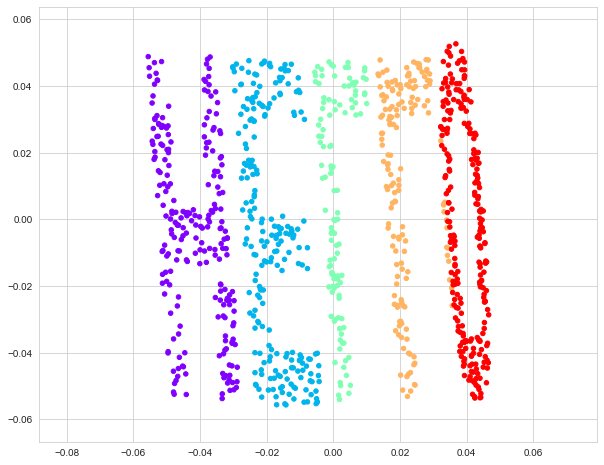

In [49]:
## Additional code here if needed

plt.figure(figsize=(10,8))
plt.scatter(X_lle[:, 0], X_lle[:, 1], **colorize)
plt.axis('equal')

plt.show()





In [ ]:
## and here








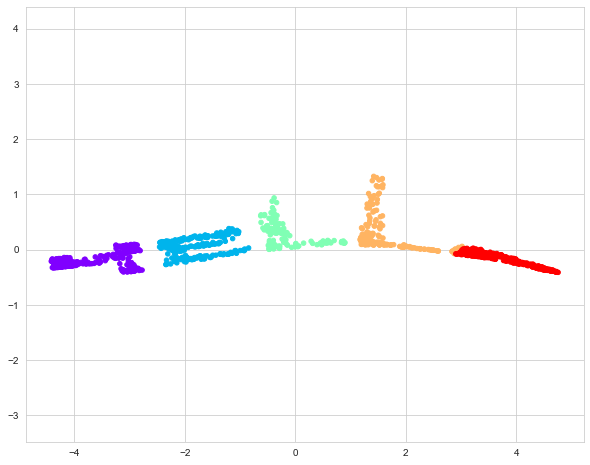

In [59]:
## Explore what happens when you change the number of 
## number of neighbors in the isomap on the XS data

iso = Isomap(n_neighbors=50, n_components=2)
X_iso = iso.fit_transform(XS)

plt.figure(figsize=(10,8))
plt.scatter(X_iso[:, 0], X_iso[:, 1], **colorize)
plt.axis('equal')

plt.show()


In [ ]:
## Additional code here if needed







In [ ]:
## and here








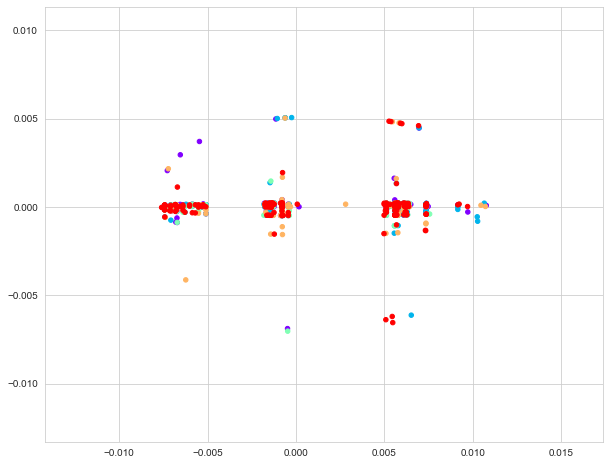

In [57]:
## Explore what happens when you change the perplexity 
## in the tSNE algorithm on the XS data
tsne = TSNE(n_components = 2, perplexity=5000, random_state = 440)
X_tsne = tsne.fit_transform(XS)

plt.figure(figsize=(10,8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], **colorize)
plt.axis('equal')

plt.show()



In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_swiss_roll

In [ ]:
## Look at the following swiss roll data
X_swiss, _ = make_swiss_roll(5000)
# Make it thinner
X_swiss[:, 1] *= .5

ward = AgglomerativeClustering(n_clusters=6, linkage='ward').fit(X_swiss)

label = ward.labels_

fig = plt.figure(figsize=(12,12))
ax = p3.Axes3D(fig)
ax.view_init(15, -80)
for l in np.unique(label):
    ax.scatter(X_swiss[label == l, 0], X_swiss[label == l, 1], X_swiss[label == l, 2],
               color=plt.cm.gist_rainbow(float(l) / np.max(label + 1)),
               s=20, edgecolor='k')

In [ ]:
## Apply whatever manifold learning techniques
## you'd like to try and "unfirl" the roll
## label the 2d data X_2




In [61]:
## run this to plot when you're ready
plt.figure(figsize=(12,12))

for l in np.unique(label):
    plt.scatter(X_2[label == l, 0], X_2[label == l, 1],
               color=plt.cm.gist_rainbow(float(l) / np.max(label + 1)),
               s=20, edgecolor='k')

NameError: name 'label' is not defined

<Figure size 864x864 with 0 Axes>